In [ ]:
!pip install pymorphy2[fast]
!pip install -U pymorphy2-dicts-ru
!pip install nltk
!pip install transformers
!pip install imblearn
!pip install stanza
!pip install allennlp

In [ ]:
import re
import random
import codecs
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pymorphy2
import nltk
from nltk.corpus import stopwords

from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn

from transformers import AutoTokenizer, AutoModel

from imblearn.under_sampling import NearMiss
import stanza

import warnings

warnings.filterwarnings('ignore')
nltk.download("stopwords")
stanza.download('ru')

In [3]:
def set_random_state(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    print(f"seed={seed} fixed")

In [23]:
def read_csv(file_name="test.csv"):
    df = pd.read_csv(file_name)
    
    print(f"Unique dialogs: {df['dlg_id'].unique().shape[0]}\n")
    print(f"Misses:\n{df.isna().sum()}\n")
    print(f"Column types:\n{df.dtypes}")
    
    return df


In [5]:
def preprocess_data(data):
    def greeting_func(sentence):
        for greeting in greetings_list:
            if re.findall(greeting, sentence.lower()):
                return 1
        
        return 0
    
    
    # role = {
    #     "client": 0,
    #     "manager": 1
    # }
    
    greetings_list = [
        "доброе утро"
        "добрый день",
        "добрый вечер",
        "здравствуйте",
        "до свидания",
        "меня зовут",
    ]
    
    df = data.copy()
    morph = pymorphy2.MorphAnalyzer()
    ru_stopwords = stopwords.words("russian")
    digits = [str(i) for i in range(10)]
    
    # df["text"] = df["text"].apply(lambda sentences: " ".join([morph.normal_forms(word)[0]
    #                                   for word in sentences.split()
    #                                   if (word not in ru_stopwords) and (word[0] not in digits)]))
    # df["role"] = df["role"].apply(lambda person: role[person])
    
    df["text"] = df["text"].apply(lambda sentences: " ".join([word for word in sentences.split()
                                                              if (word[0]) not in digits]))
    df["insight"] = df["text"].apply(lambda sentences: greeting_func(sentences))
    
    # X_train = df[(df["dlg_id"] <= 3) & (df["role"] == 1)]
    # X_test = df[(4 <= df["dlg_id"]) & (df["role"] == 1)]
    
    # X_train = df[(df["dlg_id"] <= 3)]
    # X_test = df[(4 <= df["dlg_id"])]
    
    return df

In [6]:
def data_loader(X, Y, batch_size=1):
    num_objects = X.shape[0]

    indices = np.arange(num_objects)
    np.random.shuffle(indices)

    for start in range(0, num_objects, batch_size):
        end = min(start + batch_size, num_objects)
        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]

In [7]:
def load_bert(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    
    return model, tokenizer

In [8]:
def embed_bert_cls(text, model, tokenizer):
    embedding_corpus = []
    
    for replic in text:
        t = tokenizer(replic, padding=True, truncation=True, return_tensors='pt')
        with torch.no_grad():
            model_output = model(**{k: v.to(model.device) for k, v in t.items()})
        embeddings = model_output.last_hidden_state[:, 0, :]
        embeddings = torch.nn.functional.normalize(embeddings)
        
        embedding_corpus.append(embeddings[0].cpu().numpy())
    
    return torch.tensor((embedding_corpus))

In [9]:
def make_nn_clf(in_feat, out_feat, classes=2):
    
    model = nn.Sequential(
        nn.Linear(in_feat, out_feat),
        nn.ReLU(),
        nn.BatchNorm1d(out_feat),
        nn.Linear(out_feat, out_feat),
        nn.ReLU(),
        nn.BatchNorm1d(out_feat),
        nn.Linear(out_feat, classes),
        nn.Softmax()
    )
    
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    
    return model, optimizer, criterion


In [10]:
def train(model, optimizer, criterion, epochs=50, eval_every=10 , plot=True):
    loss_history = []
    model.train()

    for epoch in range(epochs):  
        for X, y in data_loader(train_set, train_labels, batch_size=train_set.shape[0]):
            optimizer.zero_grad()
            
            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()
            
            optimizer.step()
        
        loss_history.append(loss.item())
        # print(f"avg loss epoch: {loss_history[-1] / train_set.shape[0]}")
        
        if (epoch + 1) % eval_every == 0:
            model.eval()
            
            y_test_pred = model(test_set).argmax(axis=1)
            y_train_pred = model(train_set).argmax(axis=1)
            
            print(f"Epoch: {epoch + 1}")
            print(f"Accuracy test: {accuracy_score(y_test_pred, test_labels)}")
            print(f"Accuracy train: {accuracy_score(y_train_pred, train_labels)}")
            print()
            
            model.train()
            
    if plot: 
        plt.plot(np.arange(EPOCHS), loss_history)
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.title("loss history")
        plt.show()
        
    return model

In [11]:
def evaluate(nn_model, clf, data, labels, report=True):
    nn_model.eval()
    
    clf_pred = clf.predict(data)
    one_class_pred = np.ones(shape=(labels.shape[0],))
    zero_class_pred = np.zeros(shape=(labels.shape[0],))
    nn_clf_pred = nn_model(data).detach().numpy().argmax(axis=1)
    
    nn_model.train()
    
    
    if report:
        print(f"Neural Network clf accuracy: {accuracy_score(nn_clf_pred, labels)}")
        print(f"Linear clf accuracy: {accuracy_score(clf_pred, labels)}")
        print(f"0 class accuracy: {accuracy_score(zero_class_pred, labels)}")
        print(f"1 class accuracy: {accuracy_score(one_class_pred, labels)}\n")
        
        print("Neural network clf report:")
        print(classification_report(labels, nn_clf_pred))
        print()
        
        print("Logistic Regression report:")
        print(classification_report(labels, clf_pred))
        
        

In [12]:
def make_predict(text_corpus, bert, tokenizer, clf, neural_clf=True):
    embedding = embed_bert_cls(text_corpus, bert, tokenizer)
    
    if neural_clf:
        clf.eval()
    
        pred_class = clf(embedding).argmax(axis=1)
    
        clf.train()
        
    else:
        pred_class = clf.predict(embedding)

    print(f"text: {text_corpus} - class: {pred_class}")
    

In [13]:
def save_models(nn_model, default_model):
    torch.save(nn_model.state_dict(), "./models/nn_classifier.pt")
    pickle.dump(default_model, open("./models/logreg_classifier.sav", "wb"))

In [92]:
def stanza_nlp_ru(text):
    nlp = stanza.Pipeline(lang='ru', processors='tokenize,ner')
    doc = nlp(text)

    print(*[f'entity: {ent.text}\ttype: {ent.type}' for sent in doc.sentences for ent in sent.ents], sep='\n')

Fixed seed

In [14]:
set_random_state(0)

seed=0 fixed


Preprocessing data

In [24]:
df = read_csv(file_name="./test_data/test.csv")
test_data = preprocess_data(df)

test_data.shape

Unique dialogs: 6

Misses:
dlg_id    0
line_n    0
role      0
text      0
dtype: int64

Column types:
dlg_id     int64
line_n     int64
role      object
text      object
dtype: object


(480, 5)

Loading pretrained rubert

In [ ]:
rubert, tokenizer = load_bert("cointegrated/rubert-tiny2")

Train / Test split + extracted labels

In [27]:
test_set = embed_bert_cls(test_data["text"], rubert, tokenizer)
test_labels = torch.tensor(test_data["insight"].to_numpy(), dtype=torch.int64)


test_data.shape, test_set.shape

((480, 5), torch.Size([480, 312]))

Made Neural Network classifier and train it

In [28]:
train_set = []

txt_file = codecs.open("./train_data/dialogues/dialogues.txt", "r", "utf_8_sig" )
counter = 0

for line in txt_file:
    correct_line = " ".join(re.sub("[^А-Яа-я0-9]", " ", line).split())
    
    if counter == 100000:
        break
    
    if correct_line:
        train_set.append(correct_line)
        counter += 1

train_set = np.array(train_set)
txt_file.close()

In [29]:
train_data = pd.DataFrame([])

train_data["text"] = train_set
train_data = preprocess_data(train_data)

train_data.shape

(100000, 2)

In [30]:
train_set = embed_bert_cls(train_data["text"], rubert, tokenizer)
train_labels = torch.tensor(train_data["insight"].to_numpy(), dtype=torch.int64)

train_set.shape, train_labels.shape

(torch.Size([100000, 312]), torch.Size([100000]))

Under sampling

In [31]:
nm = NearMiss()
train_set, train_labels = nm.fit_resample(train_set, train_labels)

train_set.shape, train_labels.shape

In [32]:
train_set = torch.tensor(train_set)
train_labels = torch.tensor(train_labels, dtype=torch.int64)

Train

In [33]:
FEATURES = train_set.shape[1]
OUT_FEAT = 128
CLASSES = 2


nn_clf, optimizer, criterion = make_nn_clf(in_feat=FEATURES, out_feat=OUT_FEAT, classes=CLASSES)

Epoch: 50
Accuracy test: 0.06458333333333334
Accuracy train: 0.0485

Epoch: 100
Accuracy test: 0.9583333333333334
Accuracy train: 0.96176

Epoch: 150
Accuracy test: 0.9604166666666667
Accuracy train: 0.96207

Epoch: 200
Accuracy test: 0.9583333333333334
Accuracy train: 0.96208

Epoch: 250
Accuracy test: 0.95625
Accuracy train: 0.96209

Epoch: 300
Accuracy test: 0.95625
Accuracy train: 0.96209



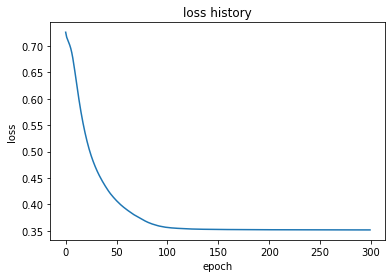

In [34]:
EPOCHS = 300
EVAL_EVERY = 50

nn_clf = train(model=nn_clf, optimizer=optimizer, criterion=criterion, epochs=EPOCHS, eval_every=EVAL_EVERY, plot=True)

I tried to make Logistic Regression, that compare it with neural network

In [35]:
def_clf = LogisticRegression(penalty="l2", class_weight="balanced")
def_clf.fit(train_set, train_labels)

LogisticRegression(class_weight='balanced')

In [36]:
evaluate(nn_model=nn_clf, clf=def_clf, data=test_set, labels=test_labels, report=True)

Neural Network clf accuracy: 0.95625
Linear clf accuracy: 0.98125
0 class accuracy: 0.96875
1 class accuracy: 0.03125

Neural network clf report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       465
           1       0.25      0.20      0.22        15

    accuracy                           0.96       480
   macro avg       0.61      0.59      0.60       480
weighted avg       0.95      0.96      0.95       480


Logistic Regression report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       465
           1       0.62      1.00      0.77        15

    accuracy                           0.98       480
   macro avg       0.81      0.99      0.88       480
weighted avg       0.99      0.98      0.98       480



Classes imbalanced

In [39]:
train_data["insight"].value_counts()

0    99681
1      319
Name: insight, dtype: int64

In [40]:
text = [
    "Отлично",
    "До свидания, Мария, мы вам перезвоним",
    "Как ваши дела?",
    "Добрый день",
    "Здравствуйте, звоним вам по поводу"
]

make_predict(text, rubert, tokenizer, nn_clf)
make_predict(text, rubert, tokenizer, def_clf, neural_clf=False)

text: ['Отлично', 'До свидания, Мария, мы вам перезвоним', 'Как ваши дела?', 'Добрый день', 'Здравствуйте, звоним вам по поводу'] - class: tensor([0, 1, 0, 0, 1])
text: ['Отлично', 'До свидания, Мария, мы вам перезвоним', 'Как ваши дела?', 'Добрый день', 'Здравствуйте, звоним вам по поводу'] - class: [0 1 0 1 1]


In [84]:
y_pred = def_clf.predict(test_set)

test_data["mark"] = y_pred

In [86]:
test_data[(test_data["mark"] == 1) & (test_data["role"] == "manager")]

,dlg_id,line_n,role,text,mark
1,0,1,manager,Алло здравствуйте,1
3,0,3,manager,Меня зовут ангелина компания диджитал бизнес з...,1
62,0,62,manager,Да мы услышали вас спасибо за рекомендации,1
108,0,108,manager,Всего хорошего до свидания,1
110,1,1,manager,Алло здравствуйте,1
111,1,2,manager,Меня зовут ангелина компания диджитал бизнес з...,1
163,1,54,manager,До свидания,1
166,2,2,manager,Алло здравствуйте,1
167,2,3,manager,Меня зовут ангелина компания диджитал бизнес з...,1
250,3,1,manager,Алло дмитрий добрый день,1


In [41]:
save_models(nn_clf, def_clf)

NER

In [87]:
extracted_replics = test_data[(test_data["mark"] == 1) & (test_data["role"] == "manager")]["text"]

In [124]:
morph = pymorphy2.MorphAnalyzer()
ru_stopwords = stopwords.words("russian")

In [ ]:
archive = load_archive("lrl-truecaser-model-ru.tar.gz")
predictor = Predictor.from_archive(archive, "truecaser-predictor")

In [ ]:
fixed_replics = []

for replic in extracted_replics:
    replic = replic.title()
    new_replic = " ".join([morph.normal_forms(word)[0] for word in replic.split()
              if (word not in ru_stopwords)])
    
    fixed_replics.append(new_replic)


for replic in fixed_replics:
    if replic:
        stanza_nlp_ru(replic.title())
